In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### data link:wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [18]:
df = pd.read_csv("housing.csv")
print(len(df))
df.head()

20640


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Data preparation
- Apply the log tranform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer to turn the dataframe into matrices.

In [19]:
cols = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households',
        'median_income','median_house_value','ocean_proximity']
df = df[cols]

In [20]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [21]:
# Fill NAs with 0
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [22]:
df.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [23]:
#Apply the log tranform to median_house_value
df.median_house_value = np.log1p(df.median_house_value)

#### train_test split

In [24]:
from sklearn.model_selection import train_test_split

In [32]:
#Use the train_test_split function and set the random_state parameter to 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

#### Use DictVectorizer to turn the dataframe into matrices

In [13]:
from sklearn.feature_extraction import DictVectorizer

In [33]:
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### Question 1
Let's train a decision tree regressor to predict the median_house_value variable.
- Train a model with max_depth=1.
Which feature is used for splitting the data?

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [39]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [43]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



### Question 2
Train a random forest model with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [45]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [46]:
y_pred = rf.predict(X_val)

In [48]:
mse = mean_squared_error(y_val,y_pred)
rmse = np.sqrt(mse)
print(mse,rmse)

0.0603873333768641 0.24573834331838426


### Question 3
Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? 

In [55]:
scores = []
 
for estimator in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=estimator,random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val,y_pred)
    rmse = np.sqrt(mse)
    scores.append((estimator,rmse))

In [58]:
df_scores = pd.DataFrame(scores, columns=['n_estimators','rmse'])
df_scores.head()

,n_estimators,rmse
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104


(0.23, 0.234)

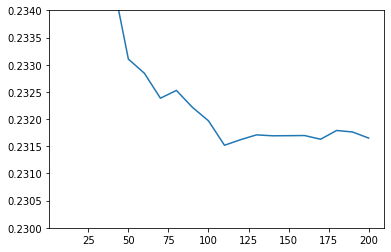

In [59]:
plt.plot(df_scores.n_estimators,df_scores.rmse)
plt.ylim(0.230,0.234)

### Question 4
Let's select the best max_depth:
- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

What's the best max_depth

In [68]:
scores = []
depths = [10, 15, 20, 25]

for depth in depths:
    for estimator in range(10,201,10):
        rf = RandomForestRegressor(n_estimators=estimator,max_depth=depth,random_state=1,n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val,y_pred)
        rmse = np.sqrt(mse)
        scores.append((depth,estimator,rmse))

In [69]:
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators','rmse'])
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.255042
1,10,20,0.252784
2,10,30,0.251647
3,10,40,0.251062
4,10,50,0.250192


In [70]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(4)

rmse                        
max_depth         10      15      20      25
n_estimators                                
10            0.2550  0.2448  0.2463  0.2461
20            0.2528  0.2393  0.2389  0.2388
30            0.2516  0.2369  0.2359  0.2355
40            0.2511  0.2360  0.2348  0.2343
50            0.2502  0.2347  0.2334  0.2327
60            0.2501  0.2347  0.2334  0.2325
70            0.2499  0.2341  0.2329  0.2320
80            0.2496  0.2340  0.2329  0.2319
90            0.2493  0.2338  0.2327  0.2317
100           0.2492  0.2335  0.2325  0.2316
110           0.2489  0.2332  0.2321  0.2313
120           0.2490  0.2332  0.2321  0.2313
130           0.2491  0.2333  0.2322  0.2315
140           0.2492  0.2333  0.2320  0.2315
150           0.2492  0.2332  0.2320  0.2315
160           0.2491  0.2331  0.2320  0.2315
170           0.2489  0.2331  0.2319  0.2314
180           0.2490  0.2332  0.2321  0.2316
190           0.2491  0.2333  0.2321  0.2316
200           0.2491  0.2333  0.2319  0.2315

<AxesSubplot:xlabel='None-max_depth', ylabel='n_estimators'>

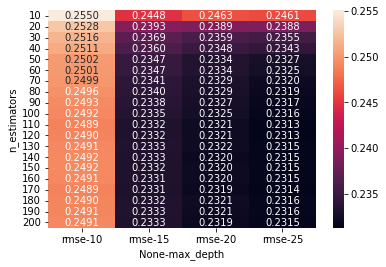

In [71]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".4f")

### For this homework question, we'll find the most important feature:

Train the model with these parametes:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this model(feature_importances_ field)
What's the most important feature

In [72]:
rf = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [76]:
gains = rf.feature_importances_
gains

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [84]:
feature_importance=pd.DataFrame({'feature':list(dv.get_feature_names_out()),'feature_importance':gains})
feature_importance.sort_values('feature_importance',ascending=False)

,feature,feature_importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


### Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

In [85]:
import xgboost as xgb

In [93]:
features = list(dv.get_feature_names_out())
features = [feature.replace("=","_") if '=' in feature else feature for feature in features]
features = [feature.replace("<","_") if '<' in feature else feature for feature in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity__1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [94]:
dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=features)
dval = xgb.DMatrix(X_val, feature_names=features)

In [96]:
scores = []

In [97]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [98]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
mse = mean_squared_error(y_val,y_pred)
rmse = np.sqrt(mse)
scores.append((xgb_params['eta'],rmse))

In [99]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [100]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
mse = mean_squared_error(y_val,y_pred)
rmse = np.sqrt(mse)
scores.append((xgb_params['eta'],rmse))

In [103]:
df_scores = pd.DataFrame(scores, columns=['eta','rmse'])
df_scores.round(4)

,eta,rmse
0,0.3,0.4323
1,0.1,4.0646
